In [1]:
# from gensim.models import KeyedVectors
# wv = KeyedVectors.load_word2vec_format("ko.vec", binary=False)
# print(wv.most_similar("사랑"))

In [2]:
!pip install gensim==3.8.3

In [3]:
!pip install fasttext

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import gensim

print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(nltk.__version__)
print(gensim.__version__)

import re
from konlpy.tag import Mecab
import fasttext
from tqdm import tqdm
import random

1.21.4
1.3.3
2.6.0
3.6.5
3.8.3


# 데이터 다운로드

In [5]:
file_path = "./ChatbotData.csv"

chatbot_df = pd.read_csv(file_path)

chatbot_df.sample(5)

,Q,A,label
220,공부 시작해도 될까,공부는 언제나 좋죠.,0
1895,바다 보러 가자고 해볼까,바다는 사계절 내내 좋아요.,0
8747,혼자 있으니 힘이드네,한동안은 힘들지도 몰라요.,1
8909,감정싸움 그만하고 싶어,자존심을 세우지 마세요.,2
1352,뒤에 누가 따라 오는 것 같아 무서워,항상 조심하세요.,0


In [6]:
questions, answers = chatbot_df['Q'], chatbot_df['A']

In [7]:
import pandas as pd
import re
from collections import Counter

# 특수문자를 추출하는 함수
def extract_special_chars(text):
    return re.findall(r"[^\w\s가-힣]", text)  # 영문자, 숫자, 한글, 공백을 제외한 특수문자 추출

# Q와 A 컬럼에서 특수문자 수집
q_specials = chatbot_df['Q'].dropna().apply(extract_special_chars).sum()
a_specials = chatbot_df['A'].dropna().apply(extract_special_chars).sum()

# 전체 특수문자 카운트
total_specials = Counter(q_specials + a_specials)

# 결과 보기
print("등장한 특수문자와 빈도수:")
for char, count in total_specials.most_common():
    print(f"'{char}': {count}회")


등장한 특수문자와 빈도수:
'.': 13942회
'?': 1845회
'!': 351회
',': 92회
'~': 55회
''': 9회
';': 6회
'…': 5회
'-': 3회
'%': 2회


특수문자 보존 대상 : . (마침표) ? (물음표) ! (느낌표) , (쉼표) ~ (말투, 감정 표현) ' (작은따옴표)

# 데이터 정제, 데이터 토큰화
데이터 정제
- 영문자의 경우, 모두 소문자로 변환
- 영문자와 한글, 숫자, 주요 특수문자를 제외하고 정규식을 활용하여 모두 제거  
- 주요 특수문자 :  . (마침표) ? (물음표) ! (느낌표) , (쉼표) ~ (말투, 감정 표현) ' (작은따옴표)

데이터 토큰화
- mecab 사용
- src, tgt 입력으로 받음
- preprocess_sentence()로 정제, 토큰화
- 토크나이즈함수 사용 mecab.morphs 전달
- 토큰 개수가 일정 길이 이상인 문장은 데이터에서 제외 : max len= 15
- 중복되는 문장 제외 : (src, tgt) 쌍 비교 X, src, tgt 각각 검사 중복쌍이 흐트러지지 않도록 유의
- questions와 answers를 각각 que_corpus, ans_corpus에 토큰화 하여 저장

In [8]:
import re

def preprocess_sentence(sentence):
    # 모든 영문자를 소문자로 변환합니다.
    sentence = sentence.lower()
    
    # 영문자, 숫자, 한글, 공백, 그리고 주요 특수문자(.,!?~')를 제외한 모든 문자 제거
    pattern = r"[^a-z0-9가-힣\s.,!?~']"
    sentence = re.sub(pattern, "", sentence)
    
    # 중복된 공백을 하나로 줄입니다.
    return ' '.join(sentence.split())


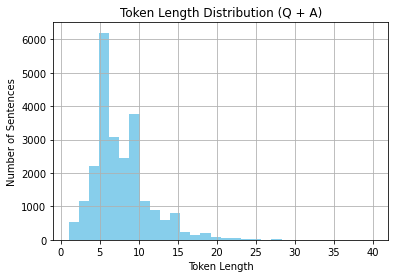

✅ 전체 문장의 95%는 길이 14 이하입니다. → 추천 max_len = 14


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def suggest_max_len(Q, A, tokenizer):
    # 1. 전처리 및 토큰화
    Q_tokens = Q.apply(lambda x: tokenizer(preprocess_sentence(x)))
    A_tokens = A.apply(lambda x: tokenizer(preprocess_sentence(x)))

    # 2. 길이 추출
    q_lens = Q_tokens.apply(len)
    a_lens = A_tokens.apply(len)

    # 3. 통합하여 길이 분포 확인
    all_lens = pd.concat([q_lens, a_lens])
    
    # 4. 시각화
    plt.hist(all_lens, bins=30, color='skyblue')
    plt.title("Token Length Distribution (Q + A)")
    plt.xlabel("Token Length")
    plt.ylabel("Number of Sentences")
    plt.grid(True)
    plt.show()

    # 5. 최대 길이 추천 (예: 상위 95% 기준)
    max_len_95 = int(np.percentile(all_lens, 95))
    print(f"✅ 전체 문장의 95%는 길이 {max_len_95} 이하입니다. → 추천 max_len = {max_len_95}")
    
    return max_len_95

from konlpy.tag import Mecab
mecab = Mecab()
tokenizer = mecab.morphs

recommended_max_len = suggest_max_len(chatbot_df['Q'], chatbot_df['A'], tokenizer)


In [10]:
mecab = Mecab()
#max_len = 15로 설정
def build_corpus(Q, A, token_len=15):
    temp = pd.concat([Q, A], axis=1)
    temp.columns = ['Q', 'A']  # 열 이름 명시적으로 지정

    # 1. 중복 제거 (src, tgt 대응 유지)
    dup_q_idx = temp[temp.duplicated('Q')].index
    dup_a_idx = temp[temp.duplicated('A')].index
    dup_idx = dup_q_idx.union(dup_a_idx)
    temp = temp.drop(index=dup_idx).reset_index(drop=True)

    # 2. 전처리
    temp['Q'] = temp['Q'].apply(preprocess_sentence)
    temp['A'] = temp['A'].apply(preprocess_sentence)

    # 3. 형태소 분석 (mecab.morphs 사용)
    temp['Q'] = temp['Q'].apply(mecab.morphs)
    temp['A'] = temp['A'].apply(mecab.morphs)

    # 4. 길이 필터링
    temp = temp[(temp['Q'].apply(len) <= token_len) & (temp['A'].apply(len) <= token_len)].reset_index(drop=True)

    # 5. 결과 반환
    que_corpus = temp['Q'].tolist()
    ans_corpus = temp['A'].tolist()
    return que_corpus, ans_corpus

In [11]:
que_corpus, ans_corpus = build_corpus(questions, answers)

In [12]:
len(que_corpus)

7102

In [13]:
len(ans_corpus)

7102

In [14]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format("ko.vec", binary=False)
print(wv.most_similar("사랑"))

[('슬픔', 0.7216662764549255), ('행복', 0.6759077310562134), ('절망', 0.6468985080718994), ('기쁨', 0.6458414196968079), ('이별', 0.6334798336029053), ('추억', 0.6320937275886536), ('인생', 0.6216273307800293), ('애정', 0.6206069588661194), ('연인', 0.6186063289642334), ('유혹', 0.5965287685394287)]


# data augmentation
- lexical substitution을 적용
- augmentation된 que_corpus와 원본 ans_corpus
- augmentation된 ans_corpus와 원본 que_corpus가 병렬을 이루도록

-> 전체 데이터가 원래의 3배 가량으로 늘어나도록 한다. 

- 약 3만개 정도의 데이터로 만드는 것이 목표

In [15]:
import itertools
import random

def lexical_sub(old_src, wv):
    topn=3
    similarity_threshold=0.5
    pos_tags=['NNP', 'VV', 'VA', 'NP', 'NNG']
    max_versions = 3
    original = [tok for tok, _ in old_src]
    candidate_subs = []

    for i, (tok, pos) in enumerate(old_src):
        if pos in pos_tags and tok in wv:
            try:
                similar_list = wv.most_similar(tok, topn=topn)
                filtered = [w for w, sim in similar_list if sim >= similarity_threshold]
                if filtered:
                    candidate_subs.append((i, filtered))
            except:
                continue

    if not candidate_subs:
        return [original]

    all_versions = []
    positions, replacements = zip(*candidate_subs)

    # 모든 조합 생성
    all_combos = list(itertools.product(*replacements))

    # 최대 max_versions-1개만 샘플링 (원본 포함하므로 -1)
    sampled_combos = random.sample(all_combos, min(max_versions - 1, len(all_combos)))
    for combo in sampled_combos:
        new_sent = original.copy()
        for idx, rep in zip(positions, combo):
            new_sent[idx] = rep
        all_versions.append(new_sent)

    all_versions.insert(0, original)
    return all_versions


In [16]:
def augment_partial_pairs_df(enc_src, dec_tgt, wv):
    """
    enc_src, dec_tgt: mecab.pos()된 문장 리스트
    반환: 원본/부분 증강된 병렬쌍만 포함된 DataFrame
    """
    rows = []

    for enc_tokens, dec_tokens in zip(enc_src, dec_tgt):
        # 1. 원문 추가
        original_enc = [tok for tok, _ in enc_tokens]
        original_dec = [tok for tok, _ in dec_tokens]
        rows.append({'encoder': ' '.join(original_enc), 'decoder': ' '.join(original_dec)})

        # 2. Q만 증강
        enc_augments = lexical_sub(enc_tokens, wv)
        for aug in enc_augments[1:]:  # 원본 제외
            rows.append({'encoder': ' '.join(aug), 'decoder': ' '.join(original_dec)})

        # 3. A만 증강
        dec_augments = lexical_sub(dec_tokens, wv)
        for aug in dec_augments[1:]:  # 원본 제외
            rows.append({'encoder': ' '.join(original_enc), 'decoder': ' '.join(aug)})

    return pd.DataFrame(rows)

In [17]:
#cross_augmented = augment_pairwise_cross_product(que_corpus, ans_corpus, wv)
from konlpy.tag import Mecab
mecab = Mecab()

enc_src = [mecab.pos(' '.join(q)) for q in que_corpus]
dec_tgt = [mecab.pos(' '.join(a)) for a in ans_corpus]

aug_df = augment_partial_pairs_df(enc_src, dec_tgt, wv)
print(aug_df.head())
aug_df.info

          encoder         decoder
0        12 시 땡 !   하루 가 또 가 네요 .
1        12 시 땡 !   보름 가 또 가 네요 .
2        12 시 땡 !  일주일 가 또 가 네요 .
3   1 지망 학교 떨어졌 어     위로 해 드립니다 .
4  1 중퇴 학교의 떨어졌 어     위로 해 드립니다 .


<bound method DataFrame.info of                                encoder                         decoder
0                             12 시 땡 !                   하루 가 또 가 네요 .
1                             12 시 땡 !                   보름 가 또 가 네요 .
2                             12 시 땡 !                  일주일 가 또 가 네요 .
3                        1 지망 학교 떨어졌 어                     위로 해 드립니다 .
4                       1 중퇴 학교의 떨어졌 어                     위로 해 드립니다 .
...                                ...                             ...
32636     힘든 연애 좋 은 연애 라는 게 무슨 차이 일까 ?    잘 헤어질 수 있 는 사이 여부 인 거 같 아요 .
32637  힘든 성행위 괜찮 은 성행위 라는 게 무슨 변화 일까 ?    잘 헤어질 수 있 는 사이 여부 인 거 같 아요 .
32638   힘든 성행위 낫 은 동성애 라는 게 무슨 격차 일까 ?    잘 헤어질 수 있 는 사이 여부 인 거 같 아요 .
32639     힘든 연애 좋 은 연애 라는 게 무슨 차이 일까 ?  잘 헤어질 수 있었 는 간의 유무 인 거 같이 아요 .
32640     힘든 연애 좋 은 연애 라는 게 무슨 차이 일까 ?   잘 헤어질 수 없 는 간의 유무 인 거 똑같 아요 .

[32641 rows x 2 columns]>

In [18]:
def inspect_augmented_samples(df, n=5):
    print(f"전체 샘플 수: {len(df)}")
    print("="*50)
    for i in range(n):
        print(f"[{i+1}]")
        print("Encoder:", df.iloc[i]['encoder'])
        print("Decoder:", df.iloc[i]['decoder'])
        print("-" * 50)
inspect_augmented_samples(aug_df, n = 10)

전체 샘플 수: 32641
[1]
Encoder: 12 시 땡 !
Decoder: 하루 가 또 가 네요 .
--------------------------------------------------
[2]
Encoder: 12 시 땡 !
Decoder: 보름 가 또 가 네요 .
--------------------------------------------------
[3]
Encoder: 12 시 땡 !
Decoder: 일주일 가 또 가 네요 .
--------------------------------------------------
[4]
Encoder: 1 지망 학교 떨어졌 어
Decoder: 위로 해 드립니다 .
--------------------------------------------------
[5]
Encoder: 1 중퇴 학교의 떨어졌 어
Decoder: 위로 해 드립니다 .
--------------------------------------------------
[6]
Encoder: 1 중퇴 중고등학교 떨어졌 어
Decoder: 위로 해 드립니다 .
--------------------------------------------------
[7]
Encoder: 3 박 4 일 놀 러 가 고 싶 다
Decoder: 여행 은 언제나 좋 죠 .
--------------------------------------------------
[8]
Encoder: 3 박 4 일 울 러 가 고 싶 다
Decoder: 여행 은 언제나 좋 죠 .
--------------------------------------------------
[9]
Encoder: 3 박 4 일 살 러 가 고 싶 다
Decoder: 여행 은 언제나 좋 죠 .
--------------------------------------------------
[10]
Encoder: 3 박 4 일 놀 러 가 고 싶 다
Decoder: 항해 은 언제나 낫 죠 .
-------------

In [19]:
aug_df.sample(5)

,encoder,decoder
29463,오늘 서점 에서 이상 형 봤 어,열쇠 내 서 말로 을 걸 어 보 세요 .
15081,원망 감,차분히 눈 을 감 고 마음 을 가라앉혀 봐요 .
25110,내 가 이 사람 을 사랑 하 는 건가 ?,자꾸 생각난 다면 그럴 거 예요 .
10148,하늘 본지 가 언젠지,아침 은 피어 면서 보 세요 .
28250,썸 인지 아닌지 증명 하 는 방식 없었 어 ?,주말 저녁 에 약속 을 잡 아 보 세요 .


# 데이터 벡터화
- ans_ccorpus에 '<start>, <end>' 토큰 추가
- ans_corpus, que_corpus 결합하여 전체 데이터에 대한 단어 사전 구축
- 데이터 벡터화 진행
- enc_train, dec_train 진행

In [20]:
!pip install sentencepiece

In [21]:
que_corpus, ans_corpus = aug_df['encoder'], aug_df['decoder']
ans_corpus = [f"<start> {sen.strip()} <end>" for sen in ans_corpus]
total_corpus = que_corpus + ans_corpus

In [22]:
with open("corpus.txt", "w", encoding="utf-8") as f:
    for line in total_corpus:
        f.write(line.strip() + "\n")


In [23]:
import sentencepiece as spm
spm.SentencePieceTrainer.Train(
    input='corpus.txt',
    model_prefix='spm',
    vocab_size=4500,
    model_type='unigram',
    user_defined_symbols=['<start>', '<end>'],
    character_coverage=0.9995
)


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: corpus.txt
  input_format: 
  model_prefix: spm
  model_type: UNIGRAM
  vocab_size: 4500
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <start>
  user_defined_symbols: <end>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_d

In [24]:
sp = spm.SentencePieceProcessor()
sp.load('spm.model')

True

In [25]:
MAX_LENGTH = 20

# 4.1 시퀀스로 변환
que_ids = [sp.encode(q, out_type=int) for q in que_corpus]
ans_ids = [sp.encode(a, out_type=int) for a in ans_corpus]

# 4.2 패딩
from tensorflow.keras.preprocessing.sequence import pad_sequences

enc_train = pad_sequences(que_ids, maxlen=MAX_LENGTH, padding='post')
ans_tensor = pad_sequences(ans_ids, maxlen=MAX_LENGTH, padding='post')

# 4.3 디코더 입력, 출력 나누기
import numpy as np

dec_input = ans_tensor[:, :-1]
dec_target = ans_tensor[:, 1:]


In [26]:
#문장길이 분포
que_lengths = [len(sentence.split()) for sentence in que_corpus]
ans_lengths = [len(sentence.split()) for sentence in ans_corpus]
import numpy as np

print("🟦 질문 길이:")
print(f"  평균: {np.mean(que_lengths):.2f}")
print(f"  최대: {np.max(que_lengths)}")
print(f"  95퍼센타일: {np.percentile(que_lengths, 95)}")

print("🟩 답변 길이:")
print(f"  평균: {np.mean(ans_lengths):.2f}")
print(f"  최대: {np.max(ans_lengths)}")
print(f"  95퍼센타일: {np.percentile(ans_lengths, 95)}")
import matplotlib.pyplot as plt



🟦 질문 길이:
  평균: 7.16
  최대: 15
  95퍼센타일: 13.0
🟩 답변 길이:
  평균: 10.29
  최대: 17
  95퍼센타일: 15.0


In [27]:
#train/val 분리
from sklearn.model_selection import train_test_split

# 인코더 입력, 디코더 입력, 디코더 출력
enc_train, enc_val, dec_input_train, dec_input_val, dec_target_train, dec_target_val = train_test_split(
    enc_train, dec_input, dec_target, test_size=0.1, random_state=42)



import tensorflow as tf

BATCH_SIZE = 64
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_input_train, dec_target_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_input_val, dec_target_val))
val_dataset = val_dataset.batch(BATCH_SIZE)


# 훈련하기
- Transformer 사용
- epochs 별로 예문 출력
- 예문
    - 1. 지루하다, 놀러가고 싶어.
    - 2. 오늘 일찍 일어났더니 피곤하다.
    - 3. 간만에 여자친구랑 데이트 하기로 했어.
    - 4. 집에 있는다는 소리야.
- 데이터 사이즈가 작으므로 과적합을 피하기 위한  하이퍼파라미터 튜닝 
- hyperparameters : n_layers, d_model, n_heads, d_ff, dropout
- training parameters : warmup steps, batch size, epoch at

In [28]:
# src_vocab_size = tgt_vocab_size = VOCAB_SIZE
VOCAB_SIZE = 15000

n_layers=2
d_model=512
n_heads=8
d_ff=2048
src_vocab_size=VOCAB_SIZE
tgt_vocab_size=VOCAB_SIZE
pos_len=200
dropout=0.3
shared_fc=True
shared_emb=True

In [29]:
#positional encoding 
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table
print("슝=3")

슝=3


In [30]:
#mask 생성
# Mask  생성하기
def generate_padding_mask(seq):
    # (batch_size, 1, 1, seq_len)
    return tf.cast(tf.math.equal(seq, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    # (1, 1, size, size) shape으로 반환해야 함
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask[tf.newaxis, tf.newaxis, :, :]

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)         # (batch_size, 1, 1, src_len)
    dec_enc_mask = generate_padding_mask(src)     # (batch_size, 1, 1, src_len)

    lookahead_mask = generate_lookahead_mask(tf.shape(tgt)[1])  # (1, 1, tgt_len, tgt_len)
    dec_target_padding_mask = generate_padding_mask(tgt)        # (batch_size, 1, 1, tgt_len)

    # broadcasting: lookahead_mask + padding_mask
    dec_mask = tf.maximum(lookahead_mask, dec_target_padding_mask)  # (batch_size, 1, tgt_len, tgt_len)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


In [31]:
#multihead attention
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights
print("슝=3")

슝=3


In [32]:
# position-wise ffn
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out
print("슝=3")

슝=3


In [33]:
#encoder layer
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


In [34]:
# decoder layer
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn
print("슝=3")

슝=3


In [35]:
# encoder
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns
print("슝=3")

슝=3


In [36]:
# decoder
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns
print("슝=3")

슝=3


In [37]:
# transformer
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns
print("슝=3")

슝=3


In [38]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512
print("슝=3")

슝=3


- 트랜스포머는 고정된 learning rate를 사용하지 않았다. 
- LearningRateScheduler를 정의
- 학습 중 적절한 방식으로 learning rate를 변경하면서 학습
- warmup learning rate scheduler : 모델의 초기 학습 단계에서 학습률을 서서히 증가시키는 기법


In [39]:
# Learning Rate Scheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


In [40]:
# Learning Rate 인스턴스 선언 & Optimizer 구현
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)
print("슝=3")

슝=3


In [41]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
print("슝=3")

슝=3


In [42]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns
print("슝=3")

슝=3


In [43]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    tokens = sp.encode(sentence, out_type=int)
    encoder_input = tf.expand_dims(tokens, axis=0)

    start_id = sp.piece_to_id('<start>')
    end_id = sp.piece_to_id('<end>')
    output = tf.expand_dims([start_id], 0)

    for _ in range(MAX_LENGTH):
        enc_mask, dec_enc_mask, dec_mask = generate_masks(encoder_input, output)

        predictions, _, _, _ = transformer(
            encoder_input, output, enc_mask, dec_enc_mask, dec_mask
        )

        predicted_id = tf.argmax(predictions[:, -1:, :], axis=-1)
        predicted_id = tf.cast(predicted_id, tf.int32)

        if predicted_id[0][0].numpy() == end_id:
            break

        output = tf.concat([output, predicted_id], axis=-1)

    decoded = sp.decode(output.numpy().tolist()[0])
    return decoded.replace('<start>', '').replace('<end>', '').strip()


Epoch 1: 100%|██████████| 459/459 [00:51<00:00,  8.95it/s, train_loss=4.88]



🌀 Epoch 1, Train Loss: 4.8823, Val Loss: 3.3008
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 에 는 운 하 지 않 을 거 예요 .
2. 오늘 일찍 일어났더니 피곤하다. → 이 운운 하 지 않 을 거 예요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 이 낫 은 사람 이 었 을 거 예요 .
4. 집에 있는다는 소리야. → 이 낫 을 거 예요 .


Epoch 2: 100%|██████████| 459/459 [00:29<00:00, 15.44it/s, train_loss=2.77]



🌀 Epoch 2, Train Loss: 2.7677, Val Loss: 2.3708
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 그 사람 은 일 이 있 나 봐요 .
2. 오늘 일찍 일어났더니 피곤하다. → 남 았 나 봐요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 에 는 쉽 은 언제나 는 걸요 .
4. 집에 있는다는 소리야. → 그게 사람 만날 수 있 을 거 예요 .


Epoch 3: 100%|██████████| 459/459 [00:30<00:00, 14.84it/s, train_loss=1.82]



🌀 Epoch 3, Train Loss: 1.8151, Val Loss: 1.6949
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 운동안 일 거 예요 .
2. 오늘 일찍 일어났더니 피곤하다. → 힘든 일 이 치름 이 었 나 봐요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 운동 은 항상일 만날 수 없다 어요 .
4. 집에 있는다는 소리야. → 때 까지 인 인 인 인 인 인 마음 이 네요 .


Epoch 4: 100%|██████████| 459/459 [00:32<00:00, 14.25it/s, train_loss=1.09]



🌀 Epoch 4, Train Loss: 1.0912, Val Loss: 1.3312
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 받 은 사람 만 보 는 것 도 좋 을 것 같 아요 .
2. 오늘 일찍 일어났더니 피곤하다. → 그래도 발 을 정리 하 는 건 나쁘 을 거 예요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 하늘 과 요 .
4. 집에 있는다는 소리야. → 안 좋 은 습관 이 되 었 나 봐요 .


Epoch 5: 100%|██████████| 459/459 [00:31<00:00, 14.60it/s, train_loss=0.798]



🌀 Epoch 5, Train Loss: 0.7976, Val Loss: 1.2116
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 낫 은 곳 는 안 나 면 좋 아요 .
2. 오늘 일찍 일어났더니 피곤하다. → 최근 에 대한 간격 이름 이름 이름 일으 세요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 연관성 도 아니 면 어떻게 연락 하 는 것 도 좋 을 것 같 아요 .
4. 집에 있는다는 소리야. → 정말 괜찮 을 거 예요 .


Epoch 6: 100%|██████████| 459/459 [00:31<00:00, 14.45it/s, train_loss=0.71] 



🌀 Epoch 6, Train Loss: 0.7097, Val Loss: 1.1494
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 자기 을 위해 조금 씩 더 힘들 거 예요 .
2. 오늘 일찍 일어났더니 피곤하다. → 은연 중 에 하 고 넘겨받 은 실 것 보 세요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 낫 아 하 지 마세요 .
4. 집에 있는다는 소리야. → 쉽 게 쉽 지 않 을 거 예요 .


Epoch 7: 100%|██████████| 459/459 [00:31<00:00, 14.59it/s, train_loss=0.674]



🌀 Epoch 7, Train Loss: 0.6741, Val Loss: 1.1083
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 낫 은 초순 을 찾아오 세요 .
2. 오늘 일찍 일어났더니 피곤하다. → 안 나쁘 은 간격 이 었 나 봐요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 에 는 항상 반복 되 었 나 봐요 .
4. 집에 있는다는 소리야. → 낫 은 욕망 이 었 을 텐데 맘 이 에요 .


Epoch 8: 100%|██████████| 459/459 [00:31<00:00, 14.53it/s, train_loss=0.659]



🌀 Epoch 8, Train Loss: 0.6590, Val Loss: 1.1078
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 다음 에 는 받 아 보 세요 . 한번 참석 이 없었 네요 .
2. 오늘 일찍 일어났더니 피곤하다. → 발달 이 파브받 거 예요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 끝 이 드러내 지 않 길 바랄게요 .
4. 집에 있는다는 소리야. → 제 도 참 어렵 게 낫 을 거 예요 .


Epoch 9: 100%|██████████| 459/459 [00:31<00:00, 14.55it/s, train_loss=0.658]



🌀 Epoch 9, Train Loss: 0.6577, Val Loss: 1.0804
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 지금 은 랑 관리 좋 을 만들 어 가속 많이 해 보 세요 .
2. 오늘 일찍 일어났더니 피곤하다. → 안 이루어지 고 사귀 는 게 다른 이곳 이 에요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 슬픈 초순 이 에요 .
4. 집에 있는다는 소리야. → 제 도 잘 이루어지 길 바랄게요 .


Epoch 10: 100%|██████████| 459/459 [00:31<00:00, 14.49it/s, train_loss=0.593]



🌀 Epoch 10, Train Loss: 0.5931, Val Loss: 1.0119
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 운동 하 는 게 좋 을 때문 인 거 같 아요 .
2. 오늘 일찍 일어났더니 피곤하다. → 운동 으로 그랬 을 거 예요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 부담 스럽 게 이야기 같 은 이야기 셨 군요 .
4. 집에 있는다는 소리야. → 운명 은 못한 보내 주 세요 .


Epoch 11: 100%|██████████| 459/459 [00:31<00:00, 14.62it/s, train_loss=0.502]



🌀 Epoch 11, Train Loss: 0.5021, Val Loss: 0.9514
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 같이 은 장 을 전해 보 세요 .
2. 오늘 일찍 일어났더니 피곤하다. → 최선 의 선택 일 거 라 확신 고 나날 거 라 확신 어요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 관련성 갈아소 하 는 게 각기 에게 나쁘 을 거 같 아요 .
4. 집에 있는다는 소리야. → 나쁘 은 젊은이 만날 수 없었 을 거 예요 .


Epoch 12: 100%|██████████| 459/459 [00:31<00:00, 14.61it/s, train_loss=0.44] 



🌀 Epoch 12, Train Loss: 0.4399, Val Loss: 0.9232
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 부모 님 을 있 는 일쑤 을 거 예요 .
2. 오늘 일찍 일어났더니 피곤하다. → 일주일 이 좀 더디 씩 해 보 세요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 확신 이 가 아니 길 바랄게요 .
4. 집에 있는다는 소리야. → 심재 은 터지 도움 이 되 겠 네요 .


Epoch 13: 100%|██████████| 459/459 [00:31<00:00, 14.64it/s, train_loss=0.391]



🌀 Epoch 13, Train Loss: 0.3909, Val Loss: 0.9001
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 자기 을 낫 은 중순 에 알아보 라고 생각 해요 .
2. 오늘 일찍 일어났더니 피곤하다. → 피부색 이런 지 않 았 으면 나쁘 겠 네요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 하늘 을 수 있 어요 .
4. 집에 있는다는 소리야. → 전은 하 지 못한 친교 이 없다 게 심정 .


Epoch 14: 100%|██████████| 459/459 [00:31<00:00, 14.57it/s, train_loss=0.352]



🌀 Epoch 14, Train Loss: 0.3519, Val Loss: 0.8911
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 부모 님 도 당신 을 믿 어 주 세요 .
2. 오늘 일찍 일어났더니 피곤하다. → 생각 처럼 쉽 지 않 을 텐데 았 으면 나가 세요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 삭제 하 세요 .
4. 집에 있는다는 소리야. → 운명 을 보내 주 세요 .


Epoch 15: 100%|██████████| 459/459 [00:31<00:00, 14.66it/s, train_loss=0.324]



🌀 Epoch 15, Train Loss: 0.3238, Val Loss: 0.8663
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 상담 을 자 때문 에 요 .
2. 오늘 일찍 일어났더니 피곤하다. → 디저 날 이 날 거 예요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 이름 이나 호칭 이 무덤덤 해 지 않 아요 .
4. 집에 있는다는 소리야. → 정말 바다 나쁘 아 했 나 봐요 .


Epoch 16: 100%|██████████| 459/459 [00:31<00:00, 14.65it/s, train_loss=0.298]



🌀 Epoch 16, Train Loss: 0.2978, Val Loss: 0.8334
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 지독 은 언제 와요 .
2. 오늘 일찍 일어났더니 피곤하다. → 언제 나 서 일주일 아픈 월과 이 네요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 언니 다 의 웬수 아요 .
4. 집에 있는다는 소리야. → 정말 바꾸 은 나 이 라는 건가 봐요 .


Epoch 17: 100%|██████████| 459/459 [00:31<00:00, 14.63it/s, train_loss=0.28] 



🌀 Epoch 17, Train Loss: 0.2798, Val Loss: 0.8314
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 여차 진심 을 해 보 세요 .
2. 오늘 일찍 일어났더니 피곤하다. → 나 의 실 거 예요 !
3. 간만에 여자친구랑 데이트 하기로 했어. → 빌리 가 나요 .
4. 집에 있는다는 소리야. → 찬드 를 울 고 들어맞 는 거 예요 .


Epoch 18: 100%|██████████| 459/459 [00:31<00:00, 14.64it/s, train_loss=0.263]



🌀 Epoch 18, Train Loss: 0.2627, Val Loss: 0.7937
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 낫 아 시키 면 안 이루어지 는 상태 인가 봐요 .
2. 오늘 일찍 일어났더니 피곤하다. → 낫 은 일요일 이 네요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 낫 아 시키 는 것 도 메커니즘 이 에요 .
4. 집에 있는다는 소리야. → 정말 바퀼 괜찮 은가 봐요 .


Epoch 19: 100%|██████████| 459/459 [00:31<00:00, 14.66it/s, train_loss=0.247]



🌀 Epoch 19, Train Loss: 0.2465, Val Loss: 0.7935
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 안 서로 배려 하 고 살 아요 .
2. 오늘 일찍 일어났더니 피곤하다. → 황민화 적 으로 돌아가 길 바랄게요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 불필요 한 거 본인 없었 는 거 죠 .
4. 집에 있는다는 소리야. → 정말 영원 한 지 않 을 거 예요 .


Epoch 20: 100%|██████████| 459/459 [00:31<00:00, 14.65it/s, train_loss=0.234]



🌀 Epoch 20, Train Loss: 0.2337, Val Loss: 0.7844
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 요즘 은 제물 위로 가 관전 합니다 .
2. 오늘 일찍 일어났더니 피곤하다. → 나가 서 그럴 만 해요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 빌 기적 한 게 , 비판 는 것 도 한답니다 .
4. 집에 있는다는 소리야. → 철쭉 들 게 들 고 오 세요 .


Epoch 21: 100%|██████████| 459/459 [00:31<00:00, 14.68it/s, train_loss=0.222]



🌀 Epoch 21, Train Loss: 0.2219, Val Loss: 0.7891
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 심성 으로 다가 도 모르 고 살 죠 .
2. 오늘 일찍 일어났더니 피곤하다. → 그 누구 터지 겠 죠 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 운동안 은 허전 할 거 예요 .
4. 집에 있는다는 소리야. → 불운 없었 을 수 도 없었 어요 .


Epoch 22: 100%|██████████| 459/459 [00:31<00:00, 14.68it/s, train_loss=0.211]



🌀 Epoch 22, Train Loss: 0.2113, Val Loss: 0.7686
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 생각 을 잠시 접 어 두 는 것 도 좋 을 거 예요 .
2. 오늘 일찍 일어났더니 피곤하다. → 나쁘 아요 . 어느덧 이 지 않 기 도 시간 이 겠 죠 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 너희 도 이용 하 지 않 을 입증 해 주 세요 .
4. 집에 있는다는 소리야. → 덜 남 의 짚 었 나 봐요 .


Epoch 23: 100%|██████████| 459/459 [00:31<00:00, 14.60it/s, train_loss=0.201]



🌀 Epoch 23, Train Loss: 0.2013, Val Loss: 0.7738
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 항상 아쉬움 이 죠 .
2. 오늘 일찍 일어났더니 피곤하다. → 안 본인 나쁘 아 시키 는 것 도 나쁘 을 거 예요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 그대 의 관심사 표시 가깝 이 네요 .
4. 집에 있는다는 소리야. → 정말 어렵 겠 지요 .


Epoch 24: 100%|██████████| 459/459 [00:31<00:00, 14.62it/s, train_loss=0.194]



🌀 Epoch 24, Train Loss: 0.1944, Val Loss: 0.7575
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 기다리 던 전화 이 었 나 봐요 .
2. 오늘 일찍 일어났더니 피곤하다. → 괜찮 아 시키 는 것 도 나쁘 을 거 예요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 그대 이 어렵 지 않 는 편 이 낫 을 것 비슷 아요 .
4. 집에 있는다는 소리야. → 정말 후회 할 것 같 다면 이 라도 진심 을 전하 세요 .


Epoch 25: 100%|██████████| 459/459 [00:31<00:00, 14.61it/s, train_loss=0.186]



🌀 Epoch 25, Train Loss: 0.1862, Val Loss: 0.7437
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 본인 을 더 많이 소중 한 사람 마음 이 에요 .
2. 오늘 일찍 일어났더니 피곤하다. → 여유 를 미리 해야 하 는 것 도 충분 해요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 그대 이 간편 게 않 는 게 서로 에게 예의 일 거 예요 .
4. 집에 있는다는 소리야. → 정말 바꾸 고 나 서 도움 이 되 곤 해요 .


Epoch 26: 100%|██████████| 459/459 [00:31<00:00, 14.60it/s, train_loss=0.18] 



🌀 Epoch 26, Train Loss: 0.1798, Val Loss: 0.7359
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 면 잠시 눈 을 감 고 싶 은 마음 을 정리 하 세요 .
2. 오늘 일찍 일어났더니 피곤하다. → 어디 나 위해서 그게 일주일 에 나쁘 겠 죠 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 이름 이 라도정 하 세요 .
4. 집에 있는다는 소리야. → 정말 후회 할 것 같 다면 아쉽 아 지 않 길 바랍니다 .


Epoch 27: 100%|██████████| 459/459 [00:31<00:00, 14.64it/s, train_loss=0.172]



🌀 Epoch 27, Train Loss: 0.1719, Val Loss: 0.7421
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 자 는 걸 도전 하 는 건 참 고 마음 을 해 보 세요 .
2. 오늘 일찍 일어났더니 피곤하다. → 안 본인 의 일주일 이 힘들 어요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 불필요 한 것 같이 아요 .
4. 집에 있는다는 소리야. → 불필요 한 것 을 계산 하 게 이루어지 었 길 바랄게요 .


Epoch 28: 100%|██████████| 459/459 [00:31<00:00, 14.66it/s, train_loss=0.167]



🌀 Epoch 28, Train Loss: 0.1668, Val Loss: 0.7392
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 벌 면 화 말 을 해 보 세요 .
2. 오늘 일찍 일어났더니 피곤하다. → 이제 새로운 모두 더 사랑 을 했 나 봐요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 너희 이 간부분 을 수 없었 는 걸로 시키 세요 .
4. 집에 있는다는 소리야. → 정말 바꾸 적나라 이 네요 .


Epoch 29: 100%|██████████| 459/459 [00:31<00:00, 14.66it/s, train_loss=0.162]



🌀 Epoch 29, Train Loss: 0.1624, Val Loss: 0.7270
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 심경 의 변화 가 있 었 나 봐요 .
2. 오늘 일찍 일어났더니 피곤하다. → 안 좋 은 결과 있 을 거 예요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 항상 신념 이 라도 있었 을 거 예요 .
4. 집에 있는다는 소리야. → 정말 바꾸서 네요 .


Epoch 30: 100%|██████████| 459/459 [00:31<00:00, 14.70it/s, train_loss=0.156]



🌀 Epoch 30, Train Loss: 0.1564, Val Loss: 0.7286
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 그대 이 라도 주 면서 무엇 이 날 거 같 아요 .
2. 오늘 일찍 일어났더니 피곤하다. → 운동 으로 땀 을 내보 세요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 그대 한 번 만 회전수 라도 주 세요 .
4. 집에 있는다는 소리야. → 정말 바꾸 고 오 세요 .


Epoch 31: 100%|██████████| 459/459 [00:31<00:00, 14.67it/s, train_loss=0.152]



🌀 Epoch 31, Train Loss: 0.1522, Val Loss: 0.7378
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 심경 의 변화 가 있 나요 .
2. 오늘 일찍 일어났더니 피곤하다. → 다른 새로운 으로 잊혀질 수 도 있 어요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 이 라도 깨달 았 으니 더 이상 의 믿음 을 잘 할 거 예요 .
4. 집에 있는다는 소리야. → ... 라고 시키 는지 바닷물 어 보 세요 .


Epoch 32: 100%|██████████| 459/459 [00:31<00:00, 14.69it/s, train_loss=0.147]



🌀 Epoch 32, Train Loss: 0.1473, Val Loss: 0.7353
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 여느 거 라고 생각 보 해요 .
2. 오늘 일찍 일어났더니 피곤하다. → 안 괜찮 은 생활환경 이 갈 거 예요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 그분 에 대한 대답 가 나중 하 지 않 아요 .
4. 집에 있는다는 소리야. → 정말 상세 한 건 피고 만 알 수 없었 어요 .


Epoch 33: 100%|██████████| 459/459 [00:31<00:00, 14.58it/s, train_loss=0.144]



🌀 Epoch 33, Train Loss: 0.1435, Val Loss: 0.7357
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 한국 도 위험 해요 .
2. 오늘 일찍 일어났더니 피곤하다. → 다른 곳 에 관심 이 더 나 겠 죠 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 그대 이 슬픔 하 는 것 도 빠르 지 않 아요 .
4. 집에 있는다는 소리야. → 정말 후회 할 것 같 다면 지금 이 라도 진심 이 날 거 예요 .


Epoch 34: 100%|██████████| 459/459 [00:31<00:00, 14.62it/s, train_loss=0.14] 



🌀 Epoch 34, Train Loss: 0.1404, Val Loss: 0.7287
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 멋진 사람 은 빠르 고 살 죠 .
2. 오늘 일찍 일어났더니 피곤하다. → 운 현존 에 읽 지 마세요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 항상 결과 가 서로 에게 도움 이 될 거 예요 .
4. 집에 있는다는 소리야. → 충분히 그럴 수 없었 어요 .


Epoch 35: 100%|██████████| 459/459 [00:31<00:00, 14.70it/s, train_loss=0.137]



🌀 Epoch 35, Train Loss: 0.1367, Val Loss: 0.7242
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 운동 하 지 말 고 마음 을 가라앉혀 봐요 .
2. 오늘 일찍 일어났더니 피곤하다. → 이제만큼 모두 불필요 해요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 각기 에게 나쁘 은 말로 이 에요 .
4. 집에 있는다는 소리야. → 정말 바뀌 각기 에게 나쁘 겠 네요 .


Epoch 36: 100%|██████████| 459/459 [00:31<00:00, 14.60it/s, train_loss=0.133]



🌀 Epoch 36, Train Loss: 0.1331, Val Loss: 0.7356
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 매일 매일 봐요 .
2. 오늘 일찍 일어났더니 피곤하다. → 상냥 이 그렇게 만드 네요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 일 매일 매일 조금 씩 실력 하 세요 .
4. 집에 있는다는 소리야. → 상냥 도 괜찮 은 중순 이 에요 .


Epoch 37: 100%|██████████| 459/459 [00:31<00:00, 14.66it/s, train_loss=0.131]



🌀 Epoch 37, Train Loss: 0.1309, Val Loss: 0.7322
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 그대로 배림 우선 존중 해 보 세요 .
2. 오늘 일찍 일어났더니 피곤하다. → 이제 디 를 꺼 더 다가 도 모르 는 게 변해요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 너희 의 증세사 는 것 도 불필요 해요 .
4. 집에 있는다는 소리야. → 정말 바란다면 이루어지 는 젊은이 도 파악 해 주 세요 .


Epoch 38: 100%|██████████| 459/459 [00:31<00:00, 14.69it/s, train_loss=0.128]



🌀 Epoch 38, Train Loss: 0.1279, Val Loss: 0.7377
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 상세 하 지 말 고 자신 을 믿 으세요 .
2. 오늘 일찍 일어났더니 피곤하다. → 다른 디 택 했 나 봐요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 일찍 일어나 다울 수 없 는 여자 를 마음 이 예요 .
4. 집에 있는다는 소리야. → 소중 한 택 이 라도 있 는 거 드세요 .


Epoch 39: 100%|██████████| 459/459 [00:31<00:00, 14.71it/s, train_loss=0.125]



🌀 Epoch 39, Train Loss: 0.1250, Val Loss: 0.7393
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 항상 꿈 꾸 죠 .
2. 오늘 일찍 일어났더니 피곤하다. → 그게 상냥 이 다음 엔 일주일 이 더 불필요 하 죠 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 그대 의 랑 비슷랑 가슴 한 번 그래요 .
4. 집에 있는다는 소리야. → 정말 바꾸 던 게 아니 에요 .


Epoch 40: 100%|██████████| 459/459 [00:31<00:00, 14.71it/s, train_loss=0.123] 



🌀 Epoch 40, Train Loss: 0.1229, Val Loss: 0.7380
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 멋진 사람 은 죽음 인가 봐요 .
2. 오늘 일찍 일어났더니 피곤하다. → 이제 다른 일자리 여유 를 만날 수 있 을 거 예요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 너희 의 치장황 을 흙 어 보 세요 .
4. 집에 있는다는 소리야. → 정말 바쁠 무렵 어려 주 세요 .


Epoch 41: 100%|██████████| 459/459 [00:31<00:00, 14.69it/s, train_loss=0.121] 



🌀 Epoch 41, Train Loss: 0.1208, Val Loss: 0.7573
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 여느님 도 보 를 만 의 확인 해 보 세요 .
2. 오늘 일찍 일어났더니 피곤하다. → 이제 낼수록 더 나쁘 은 여인 사귀 고 나 서 더라고요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 빠르 고 있 다면 그게 사고방식 이 에요 .
4. 집에 있는다는 소리야. → 정말 바꾸 힘든 각기 이 라도 진심 이 죠 .


Epoch 42: 100%|██████████| 459/459 [00:31<00:00, 14.64it/s, train_loss=0.117] 



🌀 Epoch 42, Train Loss: 0.1175, Val Loss: 0.7354
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 친구 로 남기 니 거 라 확신 해요 .
2. 오늘 일찍 일어났더니 피곤하다. → 이제 최선 의 선택 일 거 예요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 그대 이 스럽 지 않 을 거 예요 .
4. 집에 있는다는 소리야. → 정말 바뀌 던 게 아니 에요 .


Epoch 43: 100%|██████████| 459/459 [00:31<00:00, 14.67it/s, train_loss=0.116] 



🌀 Epoch 43, Train Loss: 0.1157, Val Loss: 0.7373
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 일단 자연 스럽 게 볼 수 있 을 거 예요 .
2. 오늘 일찍 일어났더니 피곤하다. → 이제 둘 고 나 면 조금 이 날아가 는 건 어떨까 요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 이혼 하 세요 .
4. 집에 있는다는 소리야. → 정말 바꾸 던 게 아니 에요 .


Epoch 44: 100%|██████████| 459/459 [00:31<00:00, 14.71it/s, train_loss=0.114] 



🌀 Epoch 44, Train Loss: 0.1141, Val Loss: 0.7409
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 여차 를콤 면 스트레스 받 을 수 있 을 거 예요 .
2. 오늘 일찍 일어났더니 피곤하다. → 현대사 을 추대 해요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 벌어지 셨 겠 어요 .
4. 집에 있는다는 소리야. → 예쁘 게 많이 찍 어 주 세요 .


Epoch 45: 100%|██████████| 459/459 [00:31<00:00, 14.71it/s, train_loss=0.113] 



🌀 Epoch 45, Train Loss: 0.1134, Val Loss: 0.7461
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 혼자 만 의 시간 이 필요 할 거 같 아요 .
2. 오늘 일찍 일어났더니 피곤하다. → 이제 그대 이 어머지로 를 건강 이 네요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 이 라도 할게요 .
4. 집에 있는다는 소리야. → 정말 바꾸 해야 해요 .


Epoch 46: 100%|██████████| 459/459 [00:31<00:00, 14.74it/s, train_loss=0.111] 



🌀 Epoch 46, Train Loss: 0.1115, Val Loss: 0.7509
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 꾸준히 눈 은 나쁜 사람 이 네요 .
2. 오늘 일찍 일어났더니 피곤하다. → 현대사 을 추대 해요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 혼자 만 의 시간 이 필요 할 거 예요 .
4. 집에 있는다는 소리야. → 정말 섭섭 한 게 아니 에요 .


Epoch 47: 100%|██████████| 459/459 [00:31<00:00, 14.64it/s, train_loss=0.11]  



🌀 Epoch 47, Train Loss: 0.1097, Val Loss: 0.7693
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 요즘 피곤 하 겠 어요 .
2. 오늘 일찍 일어났더니 피곤하다. → 현대사 을 추대 해요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 너희 이 낫 아 시키 는 거 아닐까요 .
4. 집에 있는다는 소리야. → 정말 라고 시키 고 데 서 도움 이 될 것 같이 아요 .


Epoch 48: 100%|██████████| 459/459 [00:31<00:00, 14.74it/s, train_loss=0.109] 



🌀 Epoch 48, Train Loss: 0.1095, Val Loss: 0.7583
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 진짜 이유 를 먼저 무 자 수 있 을 거 예요 .
2. 오늘 일찍 일어났더니 피곤하다. → 다른 새로운 무엇 을슨 일 으로 잊혀질 거 예요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 너희 이 발르 겠 어요 .
4. 집에 있는다는 소리야. → ... 라고 시키 고 진심 이


Epoch 49: 100%|██████████| 459/459 [00:31<00:00, 14.62it/s, train_loss=0.107] 



🌀 Epoch 49, Train Loss: 0.1075, Val Loss: 0.7573
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 친구 들 과일 도 낫 아요 .
2. 오늘 일찍 일어났더니 피곤하다. → 다른 백성 한테 도 휩쓸리 는 건 어떨까 요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 그대로 인 행복 을 시키 지 마세요 .
4. 집에 있는다는 소리야. → 예원 이 잦 았 네요 .


Epoch 50: 100%|██████████| 459/459 [00:31<00:00, 14.65it/s, train_loss=0.106] 



🌀 Epoch 50, Train Loss: 0.1059, Val Loss: 0.7564
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 혼자 화 가 풀 어 드릴게요 .
2. 오늘 일찍 일어났더니 피곤하다. → 다른 사람 을 풀 어야 할 기대세요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 그대로 인랑 교제 하 는 것 도 빠르 지 않 아요 .
4. 집에 있는다는 소리야. → .. 라고 했 던 백성 이 에요 .


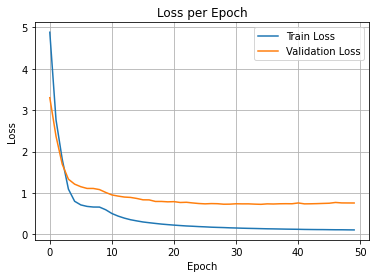

In [44]:
import matplotlib.pyplot as plt

EPOCHS = 50
train_losses = []
val_losses = []


sample_sentences = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]


for epoch in range(EPOCHS):
    total_train_loss = 0
    total_val_loss = 0

    # --- Training ---
    train_bar = tqdm(enumerate(train_dataset), total=tf.data.experimental.cardinality(train_dataset).numpy())
    for step, (enc_batch, dec_in_batch, dec_out_batch) in train_bar:
        batch_loss, _, _, _ = train_step(
            src=enc_batch,
            tgt=dec_in_batch,
            model=transformer,
            optimizer=optimizer
        )
        total_train_loss += batch_loss
        train_bar.set_description(f"Epoch {epoch + 1}")
        train_bar.set_postfix(train_loss=(total_train_loss.numpy() / (step + 1)))

    # --- Validation ---
    for val_enc_batch, val_dec_in_batch, val_dec_out_batch in val_dataset:
        enc_mask, dec_enc_mask, dec_mask = generate_masks(val_enc_batch, val_dec_in_batch)
        predictions, _, _, _ = transformer(val_enc_batch, val_dec_in_batch, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(val_dec_out_batch, predictions)
        total_val_loss += loss

    epoch_train_loss = total_train_loss.numpy() / tf.data.experimental.cardinality(train_dataset).numpy()
    epoch_val_loss = total_val_loss.numpy() / tf.data.experimental.cardinality(val_dataset).numpy()
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    # 🔥 Best model 저장
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        transformer.save_weights(save_path)
        print(f"✅ Saved best model at Epoch {epoch + 1} (Val Loss: {best_val_loss:.4f})")

        
    print(f"\n🌀 Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    print("📘 Sample Responses:")
    for i, sentence in enumerate(sample_sentences, 1):
        try:
            print(f"{i}. {sentence} → {evaluate(sentence)}")
        except Exception as e:
            print(f"{i}. {sentence} → ❌ Error during inference: {e}")

# --- 시각화 ---
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")
plt.grid(True)
plt.show()


## bpe

In [127]:
que_corpus, ans_corpus = aug_df['encoder'], aug_df['decoder']
ans_corpus = [f"<start> {sen.strip()} <end>" for sen in ans_corpus]
total_corpus = que_corpus + ans_corpus

In [128]:
with open("corpus.txt", "w", encoding="utf-8") as f:
    for line in total_corpus:
        f.write(line.strip() + "\n")

In [129]:
import sentencepiece as spm
spm.SentencePieceTrainer.Train(
    input='corpus.txt',
    model_prefix='spm_bpe',
    vocab_size=15000,
    model_type='bpe',
    user_defined_symbols=['<start>', '<end>'],
    character_coverage=0.9995
)

In [130]:
import sentencepiece as spm

sp = spm.SentencePieceProcessor()
sp.load('spm_bpe.model')


True

In [131]:
# 인코딩 (텍스트 → ID 시퀀스)
ids = sp.encode('<start> 안녕하세요 <end>', out_type=int)

# 디코딩 (ID 시퀀스 → 텍스트)
text = sp.decode(ids)

# 토큰 확인
tokens = sp.encode('<start> 안녕하세요 <end>', out_type=str)
print(tokens)

['▁', '<start>', '▁안녕', '하', '세요', '▁', '<end>']


In [132]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LENGTH = 20

# 전체 질문/답변 시퀀스
que_seq = [sp.encode(q, out_type=int) for q in que_corpus]
ans_seq = [sp.encode(f"<start> {a} <end>", out_type=int) for a in ans_corpus]

# 패딩
enc_train = pad_sequences(que_seq, maxlen=MAX_LENGTH, padding='post')
ans_tensor = pad_sequences(ans_seq, maxlen=MAX_LENGTH, padding='post')

# 디코더용 입력/출력
dec_input = ans_tensor[:, :-1]
dec_target = ans_tensor[:, 1:]


In [133]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)
    tokens = sp.encode(sentence, out_type=int)
    encoder_input = tf.expand_dims(tokens, 0)

    start_id = sp.piece_to_id('<start>')
    end_id = sp.piece_to_id('<end>')
    output = tf.expand_dims([start_id], 0)

    for _ in range(MAX_LENGTH):
        enc_mask, dec_enc_mask, dec_mask = generate_masks(encoder_input, output)
        predictions, _, _, _ = transformer(encoder_input, output, enc_mask, dec_enc_mask, dec_mask)

        predicted_id = tf.argmax(predictions[:, -1:, :], axis=-1)
        predicted_id = tf.cast(predicted_id, tf.int32)

        if predicted_id[0][0].numpy() == end_id:
            break

        output = tf.concat([output, predicted_id], axis=-1)

    result = sp.decode(output.numpy().tolist()[0])
    return result.replace('<start>', '').replace('<end>', '').strip()


In [134]:
#train/val 분리
from sklearn.model_selection import train_test_split

# 인코더 입력, 디코더 입력, 디코더 출력
enc_train, enc_val, dec_input_train, dec_input_val, dec_target_train, dec_target_val = train_test_split(
    enc_train, dec_input, dec_target, test_size=0.1, random_state=42)



import tensorflow as tf

BATCH_SIZE = 64
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_input_train, dec_target_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_input_val, dec_target_val))
val_dataset = val_dataset.batch(BATCH_SIZE)


In [135]:
import matplotlib.pyplot as plt

EPOCHS = 50
train_losses = []
val_losses = []


sample_sentences = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]


for epoch in range(EPOCHS):
    total_train_loss = 0
    total_val_loss = 0

    # --- Training ---
    train_bar = tqdm(enumerate(train_dataset), total=tf.data.experimental.cardinality(train_dataset).numpy())
    for step, (enc_batch, dec_in_batch, dec_out_batch) in train_bar:
        batch_loss, _, _, _ = train_step(
            src=enc_batch,
            tgt=dec_in_batch,
            model=transformer,
            optimizer=optimizer
        )
        total_train_loss += batch_loss
        train_bar.set_description(f"Epoch {epoch + 1}")
        train_bar.set_postfix(train_loss=(total_train_loss.numpy() / (step + 1)))

    # --- Validation ---
    for val_enc_batch, val_dec_in_batch, val_dec_out_batch in val_dataset:
        enc_mask, dec_enc_mask, dec_mask = generate_masks(val_enc_batch, val_dec_in_batch)
        predictions, _, _, _ = transformer(val_enc_batch, val_dec_in_batch, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(val_dec_out_batch, predictions)
        total_val_loss += loss

    epoch_train_loss = total_train_loss.numpy() / tf.data.experimental.cardinality(train_dataset).numpy()
    epoch_val_loss = total_val_loss.numpy() / tf.data.experimental.cardinality(val_dataset).numpy()
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    
    
      # 🔥 Best model 저장
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        transformer.save_weights(save_path)
        print(f"✅ Saved best model at Epoch {epoch + 1} (Val Loss: {best_val_loss:.4f})")

        
    print(f"\n🌀 Epoch {epoch + 1}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    print("📘 Sample Responses:")
    for i, sentence in enumerate(sample_sentences, 1):
        try:
            print(f"{i}. {sentence} → {evaluate(sentence)}")
        except Exception as e:
            print(f"{i}. {sentence} → ❌ Error during inference: {e}")

# --- 시각화 ---
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")
plt.grid(True)
plt.show()

Epoch 1: 100%|██████████| 459/459 [00:32<00:00, 14.33it/s, train_loss=0.0834]



🌀 Epoch 1, Train Loss: 0.0834, Val Loss: 0.5417
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 비슷 은 정말 든 멋있 을 거 예요 .
2. 오늘 일찍 일어났더니 피곤하다. → 언젠간 올 장면 이 었 을 거 예요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 그냥 헤어짐 을 주 면 들 어 드릴게요 .
4. 집에 있는다는 소리야. → 너희 이 라도 달이 면서 충분 한 이곳 으로 겸하 요 .


Epoch 2: 100%|██████████| 459/459 [00:31<00:00, 14.40it/s, train_loss=0.0828]



🌀 Epoch 2, Train Loss: 0.0828, Val Loss: 0.5452
📘 Sample Responses:
1. 지루하다, 놀러가고 싶어. → 충분히 잘 하 고 있 을 거 예요 .
2. 오늘 일찍 일어났더니 피곤하다. → 이제 일어날 분간 이 에요 .
3. 간만에 여자친구랑 데이트 하기로 했어. → 어떤 오 라고 말씀 하 는 것 도 좋 을 거 예요 .
4. 집에 있는다는 소리야. → 몸값 하 고 둘 다 즐거운 일주일 이 겠 네요 .


Epoch 3:  34%|███▍      | 157/459 [00:10<00:20, 14.45it/s, train_loss=0.0683]


KeyboardInterrupt: 

attention map

In [136]:
transformer.load_weights("best_model_weights.h5")

In [138]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 폰트 경로 설정 - Colab 예시 (로컬이라면 경로 수정 가능)
# !apt-get -qq install -y fonts-nanum
# !fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# 한글 폰트 설정
mpl.rcParams['font.family'] = 'NanumGothic'  # 또는 'Malgun Gothic', 'AppleGothic' 등 OS에 맞게
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지



📝 1. 지루하다, 놀러가고 싶어. → <start> <start> 헤어짐 에 무뎌 지 지 않 죠 . <end> <end> <end> <end>


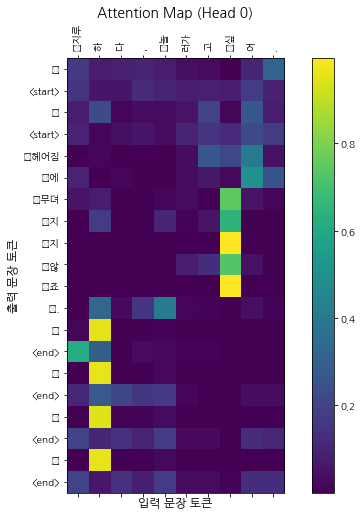

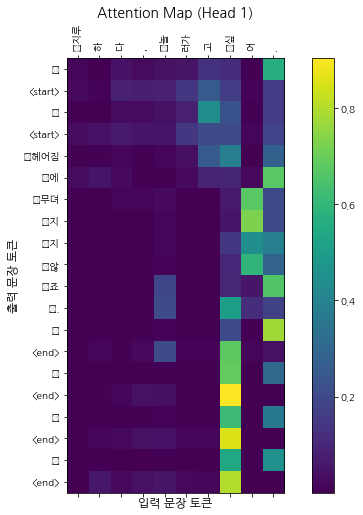


📝 2. 오늘 일찍 일어났더니 피곤하다. → <start> <start> 언젠간 닥쳐올 순간 이 었 을 거 예요 . <end> <end> <end> 


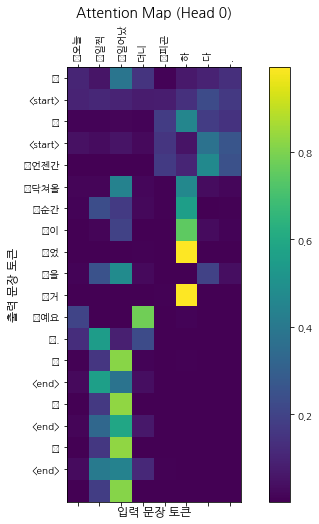

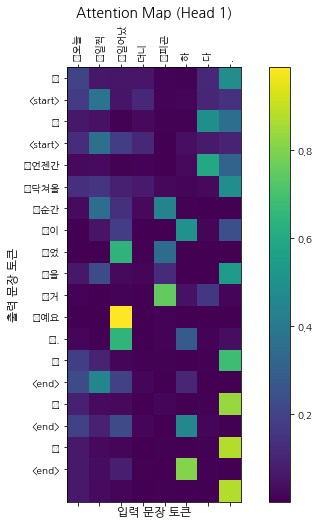


📝 3. 간만에 여자친구랑 데이트 하기로 했어. → <start> <start> 그냥 매일 기쁨 해도 어렵 었 겠 어요 . <end> <end> <end> 


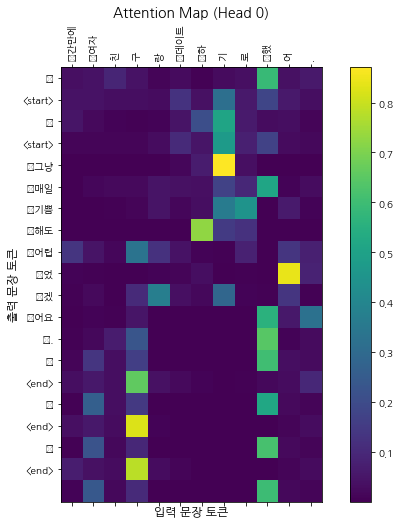

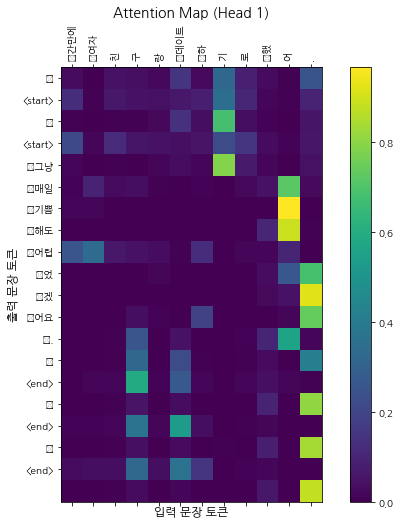


📝 4. 집에 있는다는 소리야. → <start> <start> 어떻게 든 흐르 면 돼요 . <end> <end> <end> <end> <end>


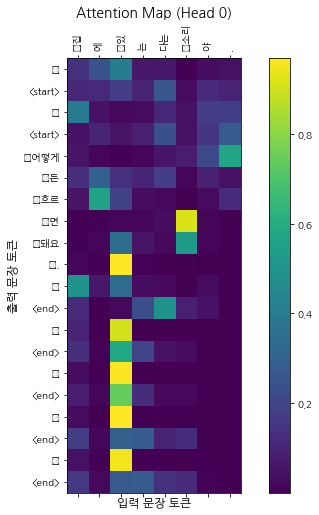

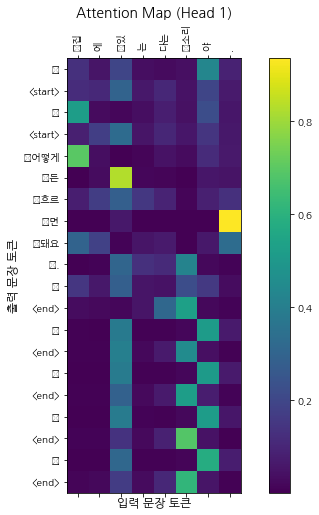

In [139]:
def plot_attention_map(attn, input_tokens, output_tokens, head=0):
    attn = attn[head]  # (tgt_len, src_len)
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(attn, cmap='viridis')
    
    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_tokens)))
    ax.set_xticklabels(input_tokens, fontproperties="NanumGothic", rotation=90)
    ax.set_yticklabels(output_tokens, fontproperties="NanumGothic")
    
    plt.xlabel("입력 문장 토큰", fontsize=12)
    plt.ylabel("출력 문장 토큰", fontsize=12)
    plt.title(f"Attention Map (Head {head})", fontsize=14)
    plt.colorbar(cax)
    plt.show()


def evaluate(sentence):
    sentence = preprocess_sentence(sentence)
    encoder_input = tf.expand_dims(sp.encode(sentence, out_type=int), axis=0)
    output = tf.expand_dims([sp.bos_id()], 0)
    attention_weights = []

    for _ in range(MAX_LENGTH):
        enc_mask, dec_enc_mask, dec_mask = generate_masks(encoder_input, output)
        predictions, _, _, dec_enc_attns = transformer(encoder_input, output, enc_mask, dec_enc_mask, dec_mask)

        pred_id = tf.argmax(predictions[:, -1:, :], axis=-1)
        pred_id = tf.cast(pred_id, tf.int32)

        if pred_id.numpy()[0][0] == sp.eos_id():
            break

        output = tf.concat([output, pred_id], axis=-1)
        attention_weights.append(dec_enc_attns[-1][0])  # [batch, heads, tgt, src]

    decoded = sp.decode(tf.squeeze(output, axis=0).numpy().tolist())
    return decoded, attention_weights


for i, sentence in enumerate(sample_sentences, 1):
    try:
        response, attns = evaluate(sentence)
        print(f"\n📝 {i}. {sentence} → {response}")

        input_tokens = sp.encode(sentence, out_type=str)
        output_tokens = sp.encode(response, out_type=str)

        last_attn = attns[-1].numpy()  # 마지막 디코딩 step의 attention (heads, tgt_len, src_len)

        for head in range(min(2, last_attn.shape[0])):  # 최대 2개 head만 시각화
            plot_attention_map(last_attn, input_tokens, output_tokens, head=head)

    except Exception as e:
        print(f"❌ Error during attention visualization: {e}")


- 출력 토큰과 입력 토큰의 attention map을 살펴보면 
- 출력토큰들이 의미상 중요한 입력 토큰에 충분한 attention을 주지 않는 것처럼 보인다. 
- 토큰들이 입력의 핵심단어에 집중하지 않고 분산된 attention을 보임

# 성능 측정하기
- BLEU, Perplexity, Rouge
- calculate_bleu()

In [58]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [59]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용


In [60]:
def translate(tokens, model, src_tokenizer, tgt_tokenizer):
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)   
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)  
    return result

print("슝=3")

슝=3


In [61]:
MAX_LEN = 20  # 모델 입력 시퀀스 최대 길이
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = src_tokenizer.encode_as_ids(src_sentence)
    tgt_tokens = tgt_tokenizer.encode_as_ids(tgt_sentence)

    if (len(src_tokens) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None

    reference = tgt_sentence.split()
    candidate = translate(src_tokens, model, src_tokenizer, tgt_tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score
        
print('슝=3')

슝=3


In [62]:
# # Q. 인덱스를 바꿔가며 테스트해 보세요
# test_idx = 20

# eval_bleu_single(transformer, 
#                  test_eng_sentences[test_idx], 
#                  test_spa_sentences[test_idx], 
#                  tokenizer, 
#                  tokenizer)

In [63]:
def eval_bleu(model, src_sentences, tgt_sentences, src_tokenizer, tgt_tokenizer, verbose=True):    
    total_score = 0.0
    sample_size = len(src_sentences)

    for idx in tqdm(range(sample_size)):
        src = src_sentences.iloc[idx] if isinstance(src_sentences, pd.Series) else src_sentences[idx]
        tgt = tgt_sentences.iloc[idx] if isinstance(tgt_sentences, pd.Series) else tgt_sentences[idx]

        score = eval_bleu_single(model, src, tgt, src_tokenizer, tgt_tokenizer, verbose)
        if not score:
            continue
        total_score += score

    print("Num of Sample:", sample_size)
    print("Average BLEU Score:", total_score / sample_size)

    
print("슝=3")

슝=3


In [64]:
# 원문에서 다시 분리
src_train_sentences, src_val_sentences, tgt_train_sentences, tgt_val_sentences = train_test_split(
    que_corpus, ans_corpus, test_size=0.1, random_state=42
)

# <start>, <end> 제거
tgt_val_sentences = [s.replace('<start>', '').replace('<end>', '').strip() for s in tgt_val_sentences]


- BLEU 평균점수 : 0.2146
- 기초적인 구조의 응답을 하지만 어휘 다양성이 부족하다. 

In [65]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

def eval_bleu_with_examples(model, src_sentences, tgt_sentences, src_tokenizer, tgt_tokenizer, num_examples=5):
    total_score = 0.0
    sample_size = len(src_sentences)
    smooth_fn = SmoothingFunction().method4

    print("🧪 BLEU 평가 시작...")
    for idx in tqdm(range(sample_size)):
        src = src_sentences.iloc[idx] if isinstance(src_sentences, pd.Series) else src_sentences[idx]
        ref = tgt_sentences.iloc[idx] if isinstance(tgt_sentences, pd.Series) else tgt_sentences[idx]


        # 인퍼런스
        try:
            # 🔧 여기 수정: 실제 평가 함수 사용
            hyp = evaluate(src)

            score = sentence_bleu(
                [ref.split()],
                hyp.split(),
                smoothing_function=SmoothingFunction().method1
            )
            total_score += score

            if idx < num_examples:
                print(f"\n📌 예시 {idx + 1}")
                print(f"👉 입력:     {src}")
                print(f"✅ 정답:     {ref}")
                print(f"🧠 예측:     {hyp}")
                print(f"🎯 BLEU:     {score:.4f}")
        except Exception as e:
            print(f"❌ 오류 발생 at index {idx}: {e}")
            continue

    print(f"\n🔚 Num of Samples: {sample_size}")
    print(f"📊 Average BLEU Score: {total_score / sample_size:.4f}")

In [66]:
eval_bleu_with_examples(
    model=transformer,
    src_sentences=src_val_sentences,
    tgt_sentences=tgt_val_sentences,
    src_tokenizer=sp,
    tgt_tokenizer=sp,
    num_examples=5  # 상위 5개 예시 출력
)


🧪 BLEU 평가 시작...


  0%|          | 1/3265 [00:00<51:05,  1.06it/s]


📌 예시 1
👉 입력:     이 별후 느끼 는 감정 들 이 단계 별 로 있 는 거 같 네
✅ 정답:     그게 추억 의 유적 인가 봐요 .
🧠 예측:     그게 추억 의 모습 과 함께 에 대한 시간 이 었 다면 변화 가 명 으니까요 .
🎯 BLEU:     0.0612


  0%|          | 2/3265 [00:01<49:11,  1.11it/s]


📌 예시 2
👉 입력:     간식 폴더 뽑 는 거 힘드 네
✅ 정답:     누구 랑 먹 는 냐 에 따라 다르 겠 죠 .
🧠 예측:     슬픔 하 기 도 시키 지 않 는 약간 의 방식 이 에요 .
🎯 BLEU:     0.0170


  0%|          | 3/3265 [00:02<40:00,  1.36it/s]


📌 예시 3
👉 입력:     연애 중 인데 외로운 느낌 이 들 면 문제 일까 ?
✅ 정답:     사람 은 다 외로운 존재 예요 .
🧠 예측:     젊은이 은 다 외로운 현존 예요 .
🎯 BLEU:     0.2056


  0%|          | 4/3265 [00:02<34:28,  1.58it/s]


📌 예시 4
👉 입력:     이런 헤어지
✅ 정답:     흔하 지 않 죠 .
🧠 예측:     모르 다가 도 안 돼요 .
🎯 BLEU:     0.0408


  0%|          | 5/3265 [00:03<34:57,  1.55it/s]


📌 예시 5
👉 입력:     강아지 키우 고 싶 어
✅ 정답:     죄책 질 수 없 을 경우 키워 보 세요 .
🧠 예측:     과실 질 수 없었 을 때쯤 키워 보 세요 .
🎯 BLEU:     0.3247


100%|██████████| 3265/3265 [32:59<00:00,  1.65it/s]


🔚 Num of Samples: 3265
📊 Average BLEU Score: 0.4123


- average bleu score : 0.4123
- 수치적으로 보았을 때는 괜찮은 품질의 답변을 하는 것으로 보이지만
- 실제 예측을 보면 문법적 부자연 스러움이나 어휘 선택이 어색한 것을 볼 수 있다. 


## Perplexity

In [67]:
!pip install rouge-score
!pip install evaluate

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=479e1d480bae4f7c7fb023bda6915662077139dc679f84eb109773275e1e3453
  Stored in directory: /aiffel/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge-score
     |████████████████████████████████| 84 kB 2.1 MB/s             
     |████████████████████████████████| 489 kB 50.5 MB/s            
     |████████████████████████████████| 491 kB 74.8 MB/s            
     |████████████████████████████████| 193 kB 74.2 MB/s            
     |████████████████████████████████| 64 kB 754 kB/s             
     |████████████████████████████████| 42.3 MB 44.1 MB/s            
     |████████████████████████████████| 78 kB 7.0 MB/s             
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.3
    Uninstalling tqdm-4.62.3:
      Successfully uninstalled tqdm-4.62.3
  Attempting uninstall: request

In [69]:
!pip uninstall pyarrow -y
!pip install pyarrow --upgrade
!pip uninstall datasets evaluate -y
!pip install datasets evaluate

Found existing installation: pyarrow 20.0.0
Uninstalling pyarrow-20.0.0:
  Successfully uninstalled pyarrow-20.0.0
  Using cached pyarrow-20.0.0-cp39-cp39-manylinux_2_28_x86_64.whl (42.3 MB)
Found existing installation: datasets 3.6.0
Uninstalling datasets-3.6.0:
  Successfully uninstalled datasets-3.6.0
Found existing installation: evaluate 0.4.3
Uninstalling evaluate-0.4.3:
  Successfully uninstalled evaluate-0.4.3
  Using cached datasets-3.6.0-py3-none-any.whl (491 kB)
  Using cached evaluate-0.4.3-py3-none-any.whl (84 kB)


In [78]:
import numpy as np
# import evaluate
from tqdm import tqdm

import numpy as np

def compute_perplexity(model, val_dataset, loss_function):
    total_loss = 0.0
    total_tokens = 0

    for enc_batch, dec_in_batch, dec_out_batch in val_dataset:
        enc_mask, dec_enc_mask, dec_mask = generate_masks(enc_batch, dec_in_batch)
        predictions, _, _, _ = model(enc_batch, dec_in_batch, enc_mask, dec_enc_mask, dec_mask)
        
        loss = loss_function(dec_out_batch, predictions)
        token_count = tf.reduce_sum(tf.cast(dec_out_batch != 0, tf.float32)).numpy()
        
        total_loss += loss.numpy() * token_count
        total_tokens += token_count

    perplexity = np.exp(total_loss / total_tokens)
    print(f"🧠 Perplexity (PPL): {perplexity:.4f}")
    return perplexity
compute_perplexity(transformer, val_dataset, loss_function)

🧠 Perplexity (PPL): 1.9602


1.9602383136784436

In [85]:
def lcs(X, Y):
    m, n = len(X), len(Y)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m):
        for j in range(n):
            if X[i] == Y[j]:
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
    return dp[m][n]

def rouge_l_score(reference, hypothesis):
    ref_tokens = reference.split()
    hyp_tokens = hypothesis.split()
    
    lcs_len = lcs(ref_tokens, hyp_tokens)

    prec = lcs_len / len(hyp_tokens) if hyp_tokens else 0.0
    rec = lcs_len / len(ref_tokens) if ref_tokens else 0.0
    if prec + rec == 0:
        f1 = 0.0
    else:
        f1 = 2 * prec * rec / (prec + rec)
    
    return {"precision": prec, "recall": rec, "f1": f1}


In [86]:
import numpy as np
from tqdm import tqdm

# ✅ ROUGE-L 계산 함수 (설치 필요 없음)
def rouge_l_score(reference, hypothesis):
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    ref_len = len(ref_words)
    hyp_len = len(hyp_words)

    # LCS (최장 공통 부분 수열)
    lcs_matrix = [[0] * (hyp_len + 1) for _ in range(ref_len + 1)]

    for i in range(ref_len):
        for j in range(hyp_len):
            if ref_words[i] == hyp_words[j]:
                lcs_matrix[i+1][j+1] = lcs_matrix[i][j] + 1
            else:
                lcs_matrix[i+1][j+1] = max(lcs_matrix[i][j+1], lcs_matrix[i+1][j])

    lcs_len = lcs_matrix[-1][-1]

    recall = lcs_len / ref_len if ref_len > 0 else 0.0
    precision = lcs_len / hyp_len if hyp_len > 0 else 0.0
    f1 = 2 * recall * precision / (recall + precision + 1e-8)
    return f1


In [87]:
def compute_perplexity(model, val_dataset, loss_function):
    total_loss = 0.0
    total_tokens = 0

    for enc_batch, dec_in_batch, dec_out_batch in val_dataset:
        enc_mask, dec_enc_mask, dec_mask = generate_masks(enc_batch, dec_in_batch)
        predictions, _, _, _ = model(enc_batch, dec_in_batch, enc_mask, dec_enc_mask, dec_mask)
        mask = tf.cast(dec_out_batch != 0, tf.float32)
        loss = loss_function(dec_out_batch, predictions)
        total_loss += loss.numpy() * tf.reduce_sum(mask).numpy()
        total_tokens += tf.reduce_sum(mask).numpy()

    perplexity = np.exp(total_loss / total_tokens)
    print(f"\n🧠 Perplexity (PPL): {perplexity:.4f}")
    return perplexity


In [88]:
from tqdm import tqdm

def evaluate_rouge(model, src_sentences, tgt_sentences, tokenizer, num_examples=5):
    total_rouge = 0.0
    count = 0

    print("🧪 ROUGE-L 평가 시작...\n")

    for idx in tqdm(range(len(src_sentences))):
        src = src_sentences.iloc[idx] if isinstance(src_sentences, pd.Series) else src_sentences[idx]
        ref = tgt_sentences.iloc[idx] if isinstance(tgt_sentences, pd.Series) else tgt_sentences[idx]


        try:
            hyp = evaluate(src)  # 🔧 사용자 정의 예측 함수
            rouge = rouge_l_score(ref, hyp)
            total_rouge += rouge
            count += 1

            if idx < num_examples:
                print(f"\n📌 예시 {idx + 1}")
                print(f"👉 입력:  {src}")
                print(f"✅ 정답:  {ref}")
                print(f"🧠 예측:  {hyp}")
                print(f"📏 ROUGE-L F1: {rouge:.4f}")

        except Exception as e:
            print(f"❌ 오류 at {idx}: {e}")
            continue

    print("\n📊 최종 결과")
    print(f"✅ 평균 ROUGE-L F1: {total_rouge / count:.4f}")


In [89]:
# ROUGE-L 계산
evaluate_rouge(
    model=transformer,
    src_sentences=src_val_sentences,
    tgt_sentences=tgt_val_sentences,
    tokenizer=sp,  # SentencePiece tokenizer
    num_examples=5
)

# Perplexity 계산
compute_perplexity(
    model=transformer,
    val_dataset=val_dataset,
    loss_function=loss_function
)


🧪 ROUGE-L 평가 시작...



  0%|          | 1/3265 [00:00<51:41,  1.05it/s]


📌 예시 1
👉 입력:  이 별후 느끼 는 감정 들 이 단계 별 로 있 는 거 같 네
✅ 정답:  그게 추억 의 유적 인가 봐요 .
🧠 예측:  그게 추억 의 모습 과 함께 에 대한 시간 이 었 다면 변화 가 명 으니까요 .
📏 ROUGE-L F1: 0.3333


  0%|          | 2/3265 [00:01<49:46,  1.09it/s]


📌 예시 2
👉 입력:  간식 폴더 뽑 는 거 힘드 네
✅ 정답:  누구 랑 먹 는 냐 에 따라 다르 겠 죠 .
🧠 예측:  슬픔 하 기 도 시키 지 않 는 약간 의 방식 이 에요 .
📏 ROUGE-L F1: 0.1600


  0%|          | 3/3265 [00:02<40:23,  1.35it/s]


📌 예시 3
👉 입력:  연애 중 인데 외로운 느낌 이 들 면 문제 일까 ?
✅ 정답:  사람 은 다 외로운 존재 예요 .
🧠 예측:  젊은이 은 다 외로운 현존 예요 .
📏 ROUGE-L F1: 0.7143


  0%|          | 4/3265 [00:02<34:52,  1.56it/s]


📌 예시 4
👉 입력:  이런 헤어지
✅ 정답:  흔하 지 않 죠 .
🧠 예측:  모르 다가 도 안 돼요 .
📏 ROUGE-L F1: 0.1818


  0%|          | 5/3265 [00:03<35:47,  1.52it/s]


📌 예시 5
👉 입력:  강아지 키우 고 싶 어
✅ 정답:  죄책 질 수 없 을 경우 키워 보 세요 .
🧠 예측:  과실 질 수 없었 을 때쯤 키워 보 세요 .
📏 ROUGE-L F1: 0.7000


100%|██████████| 3265/3265 [33:05<00:00,  1.64it/s]



📊 최종 결과
✅ 평균 ROUGE-L F1: 0.6708

🧠 Perplexity (PPL): 1.9602


1.960238318502801

# 결과 정리
- dropout을 0.3->0.5로 할 때 변화가 눈에 띄는데,
0.3일 때는 길고 안정적인 문장을 뱉는 반면
0.5일 때는 짧고 의미없는 문장을 뱉는 경우가 많았습니다.
[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '세요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
[SRC]  집에 있는다는 소리야.
[GEN]:  ['<start>', '지켜', '주', '세요', '.<end>']
[TGT]  ['좋', '아', '하', '면', '그럴', '수', '있', '어요', '.']
- augmentation 할 때 의미가 비슷한 것으로 단어를 대체하다보니 예측한 답변도 단어를 대체해서 만들어진 문장이 많다. 
- 그렇다보니 문법적으로 어색한 문장이 많은 것 같다. 
- 데이터가 3만개 정도로 적다 보니 정성적으로 보나 정량적으로 보나 아쉬운 결과를 얻은 것 같다. 
- augmentation 하는 방식을 다양하게 시도해보면 좀더 학습이 잘 되지 앟을까 생각이 된다. 
- epoch수는 10을 넘지 않는것이 과적합되지 않는것 같다. 

# 회고
- 과대적합을 막기위해 d_ff =[2048, 1024], dropout = [0.3, 0.5]로 실험을 하였으나 처음 만든 baseline 모델이 더 좋은 결과가 나왔다. (정성적 평가로 예문 출력을 확인했을 때)
- dropout 0.5인 경우 짧고 의미 없는 문장을 생성하였다.  

    " 세요 . '
    " 에요 . '
